# Stroke Prediction

**Table of Contents**<a id='toc0_'></a>    
- 1. [Introduction   ](#toc1_)    
- 2. [Notebook and Data Preparation   ](#toc2_)    
- 3. [Exploratory Data Analysis   ](#toc3_)    
  - 3.1. [Feature and Target Relationships ](#toc3_1_)    
  - 3.2. [Variable Realtionships ](#toc3_2_)    
  - 3.3. [Possible Age Effect ](#toc3_3_)    
  - 3.4. [Summary on Exploratory Data Analysis ](#toc3_4_)    
- 4. [Statistical Inference   ](#toc4_)    
  - 4.1. [Summary on Statistical Inference ](#toc4_1_)    
- 5. [Model for Stroke Prediction   ](#toc5_)    
  - 5.1. [Model Selection ](#toc5_1_)    
  - 5.2. [Important Features and Threshold Tuning ](#toc5_2_)    
  - 5.3. [Model Evaluation ](#toc5_3_)    
    - 5.3.1. [Training Set ](#toc5_3_1_)    
    - 5.3.2. [Test Set ](#toc5_3_2_)    
  - 5.4. [Model Interpretation ](#toc5_4_)    
  - 5.5. [Model Deployment](#toc5_5_)    
  - 5.6. [Summary on Model for Stroke Prediction](#toc5_6_)    
- 6. [Recommendations   ](#toc6_)    
- 7. [Suggestions for Improvement   ](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Note that the links in the above table of contents do not work on GitHub or Google Colab. In Google Colab, please use its embedded table of contents.

## 1. <a id='toc1_'></a>Introduction    [&#8593;](#toc0_)

The [World Health Organization](https://www.emro.who.int/health-topics/stroke-cerebrovascular-accident/index.html) states: 

> "Annually, 15 million people worldwide suffer a stroke. Of these, 5 million die and another 5 million are left permanently disabled, placing a burden on family and community. Stroke is uncommon in people under 40 years; when it does occur, the main cause is high blood pressure." 

Given the available dataset, the local hospital has asked to build a model to predict whether a patient is likely to get a stroke. The dataset contains these columns:
* gender: male, female or other
* age 
* hypertension: 0 for no, 1 for yes
* heart_disease: 0 for no, 1 for yes
* ever_married: no or yes
* work_type: children, govt_job, never_worked, private, self-employed
* residence_type: rural or urban
* avg_glucose_level: average glucose level in blood (mg/dL)
* bmi: body mass index ($kg/m^2$)
* smoking_status: formerly_smoked, never_smoked, smokes, unknown (missing)
* stroke: 0 for no, 1 for yes

The hospital is willing to review false positive predictions as long as at least 80% of patients at high risk of stroke are identified. Because the positive class (stroke event) is more important in this task, the model is optimized for the best average precision. The average precision metric can be thought of as an alias to the area under the precision-recall curve. The decision threshold of the model optimized for the best average precision should be tuned as the last step to obtained the desired recall and maximum precision at this recall.

The **aim** of this work is to analyze [Stroke Prediction Dataset](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) and provide insights for the hospital.

The work **objectives** are as follows:
* Explore the dataset to identify relationships between variables;
* Formulate and test relevant statistical hypothesis;
* Build and locally deploy a model to predict whether the patient is likely to get a stroke.

## 2. <a id='toc2_'></a>Notebook and Data Preparation    [&#8593;](#toc0_)

Import libraries for data analysis, visualization and modelling. Set parameters for display.

In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import phik
from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from helper_functions import custom_plots, custom_model, custom_pipes

# Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from yellowbrick.classifier import DiscriminationThreshold
from sklego.meta import Thresholder
from boruta import BorutaPy
import shap

# Display
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.labelsize": 11,
    "figure.figsize": (6, 4),
    "figure.autolayout": True,  
    "patch.edgecolor": "w",
    "patch.linewidth": 0.5,
    "legend.frameon": False,
    "axes.titlesize": "large",
    "figure.titlesize":   "large", 
}
sns.set_theme(style="whitegrid", rc=custom_params)
pd.set_option("display.precision", 3)
facecolor = sns.color_palette()[0]
emphasiscolor = sns.color_palette()[3]

%matplotlib inline
%config InlineBackend.figure_format = 'png'

Download the dataset from [Kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset), if it is not already in the `data` folder, and load it. For the method provided below to work, [Kaggle API](https://github.com/Kaggle/kaggle-api) needs to be configured on the system:

In [2]:
dataset_file = "./data/healthcare-dataset-stroke-data.csv"

if not os.path.exists(dataset_file):
    !kaggle datasets download --unzip fedesoriano/stroke-prediction-dataset -p data
else:
    print("Data already downloaded")

data = pd.read_csv(dataset_file, index_col="id")
data.rename(columns={"Residence_type": "residence_type"}, inplace=True)
data.head()

Data already downloaded


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Stroke prediction dataset has 5110 instances with unique identifiers and 11 columns. There are no duplicates in the dataset.

In [3]:
num_rows, num_cols = data.shape
feature_cols = data.columns.drop("stroke")

print(f"Number of instances: {num_rows} \nNumber of columns: {num_cols}")

print("Number of duplicate instances: ", sum(data[feature_cols].duplicated()))

Number of instances: 5110 
Number of columns: 11
Number of duplicate instances:  0


The dataset is highly imbalanced as the class of interest (patients who had stroke) is much less frequent. Such patients constitute less than 5% of the dataset.

In [4]:
data["stroke"].value_counts(dropna=False)

0    4861
1     249
Name: stroke, dtype: int64

To get roughly 50 stroke positive instances for testing, the dataset is split into train and test sets using the proportion of 80/20. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns="stroke"),
    data["stroke"],
    test_size=0.2,
    stratify=data["stroke"],
    random_state=42,
)
X_train.to_pickle("X_train.pkl")
y_train.to_pickle("y_train.pkl")

## 3. <a id='toc3_'></a>Exploratory Data Analysis    [&#8593;](#toc0_)

Exploratory data analysis is performed only on the training set. For visualization purposes, column names and category names are changed.

In [6]:
data_eda = X_train.copy()
data_eda["stroke"] = y_train
data_eda.columns = data_eda.columns.str.replace("_", " ").str.title()
data_eda.rename(columns={"Bmi": "BMI"}, inplace=True)
cols_replace = ["Hypertension", "Heart Disease", "Stroke"]
data_eda[cols_replace] = data_eda[cols_replace].replace({1: "Yes", 0: "No"})
data_eda["Work Type"] = data_eda["Work Type"].str.replace("_", " ").str.title()
data_eda["Smoking Status"] = data_eda["Smoking Status"].str.replace("_", " ")
data_eda["Smoking Status"] = data_eda["Smoking Status"].str.title()
data_eda.head()

,Gender,Age,Hypertension,Heart Disease,Ever Married,Work Type,Residence Type,Avg Glucose Level,BMI,Smoking Status,Stroke
id,,,,,,,,,,,
25283,Female,48.0,No,No,Yes,Private,Urban,69.21,33.1,Never Smoked,No
43734,Male,15.0,No,No,No,Private,Rural,122.25,21.0,Never Smoked,No
47113,Female,67.0,No,No,Yes,Self-Employed,Rural,110.42,24.9,Never Smoked,No
56996,Male,44.0,No,No,Yes,Private,Urban,65.41,24.8,Smokes,No
26325,Male,14.0,No,No,No,Govt Job,Urban,82.34,31.6,Unknown,No


There are 3 numerical features and one of them (BMI) contains missing values. However, category "Unknown" can also be considered as missing value for Smoking Status feature.

In [7]:
data_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4088 entries, 25283 to 31836
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             4088 non-null   object 
 1   Age                4088 non-null   float64
 2   Hypertension       4088 non-null   object 
 3   Heart Disease      4088 non-null   object 
 4   Ever Married       4088 non-null   object 
 5   Work Type          4088 non-null   object 
 6   Residence Type     4088 non-null   object 
 7   Avg Glucose Level  4088 non-null   float64
 8   BMI                3918 non-null   float64
 9   Smoking Status     4088 non-null   object 
 10  Stroke             4088 non-null   object 
dtypes: float64(3), object(8)
memory usage: 383.2+ KB


### 3.1. <a id='toc3_1_'></a>Feature and Target Relationships  [&#8593;](#toc0_)

The distribution of age is almost uniform. The age is provided as an integer number unless under the age of 2. It is apparent that stroke is much more common among older individuals. It seems that there is an outlier patient with stroke at very young age. Only a couple of patients below 40 years old suffered from stroke. Thus, it could be reasonable to adjust EDA to older patients, e.g., older than 35.

The distribution of BMI is right-skewed. The box-plot indicates many outliers, 2 values are above 90 kg/$m^2$. However, adults with BMI above 45 kg/$m^2$ are considered morbidly obese.  Also, BMI is used differently for people aged 2 to 20. Instead of comparison against fixed thresholds for underweight and overweight, the BMI is compared against the percentiles for children or youth of the same sex and age. Interpretation of BMI is also different for children under 2 years old. The median BMI is a bit higher in patients with stroke, but the distinction is not so clear as in the case of age. The median value of BMI in this dataset is 28 which is considered overweight.

Distribution of Average Glucose Level is right-skewed and bimodal. The second peak might indicate people suffering from diabetes. However, the range of values seems reasonable as values of up to 380 mg/dL after eating are reported in the literature. The median average glucose level is a bit higher in patients with stroke, but the distinction is not so clear as in the case of age.

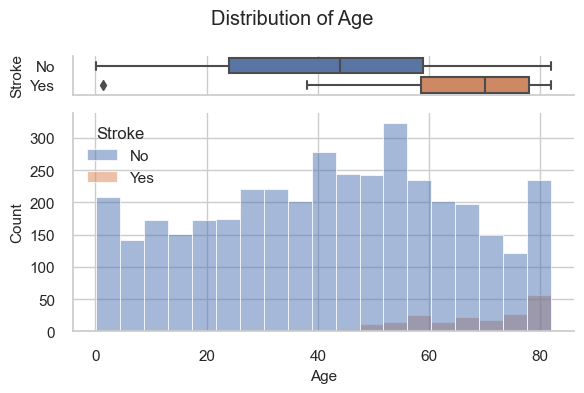

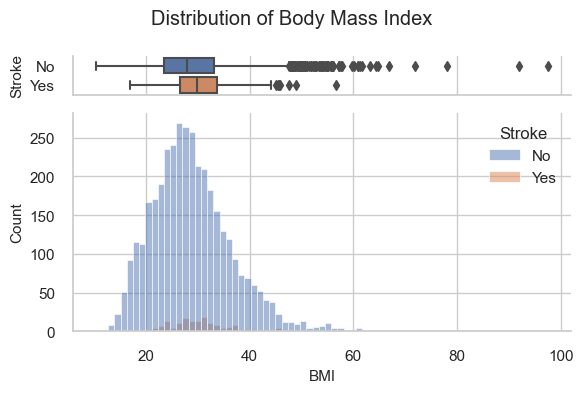

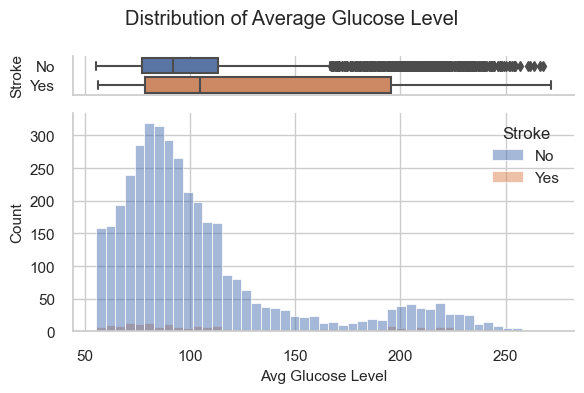

In [8]:
num_cols = ["Age", "BMI", "Avg Glucose Level"]
titles = [
    "Distribution of Age",
    "Distribution of Body Mass Index",
    "Distribution of Average Glucose Level",
]
for col, title in zip(num_cols, titles):
    custom_plots.hist_box_plot(data_eda, x=col, hue="Stroke", title=title)


plt.show()

It must be very difficult for any kind of ML algorithm to predict risk of stroke for a child or young individual. At least, with this limited amount of data. Only 3 patients under the age of 40 suffered from stroke.

In [9]:
data_eda[(data_eda["Age"] < 40) & (data_eda["Stroke"] == "Yes")]

,Gender,Age,Hypertension,Heart Disease,Ever Married,Work Type,Residence Type,Avg Glucose Level,BMI,Smoking Status,Stroke
id,,,,,,,,,,,
36338,Female,39.00,Yes,No,Yes,Private,Rural,58.09,39.2,Smokes,Yes
69768,Female,1.32,No,No,No,Children,Urban,70.37,NaN,Unknown,Yes
31720,Female,38.00,No,No,No,Self-Employed,Urban,82.28,24.0,Formerly Smoked,Yes


Proportion of stroke events by categorical features provide these insights:
* Hypertension and heart disease might contribute to stroke events. However, this might also be the effect of age since all diseases are more common in older people.
* Marital status seems as related to stroke, but this could also be the effect of age as more older people are more likely to be ever married.
* Self-employed patients tend to have stroke more often than people working in private or government sector. Seems that "Children" and "Never Worked" categories can be merged as the former is very small and might also be related to younger age.
* Those who smoke or formerly smoked exhibit higher rate of stroke. However, it is unclear how unknown smoking status can be related to other features.
* Gender and residence type features seem as unrelated to stroke events as the proportions differ by 0.5%.

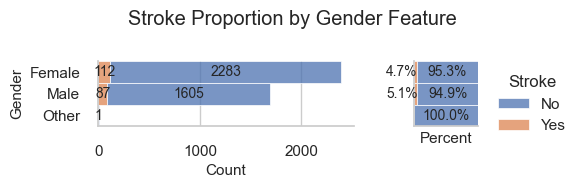

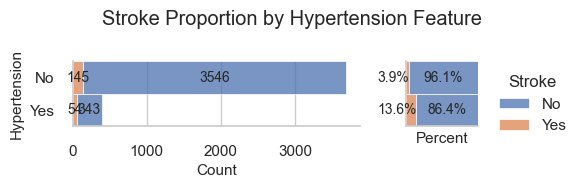

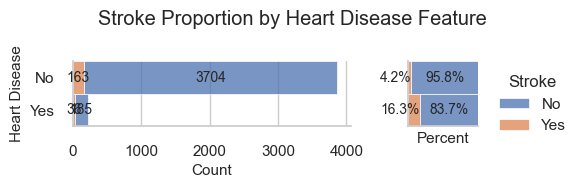

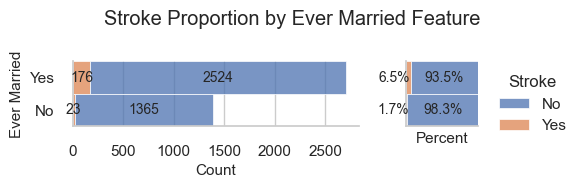

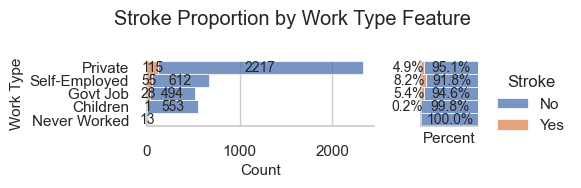

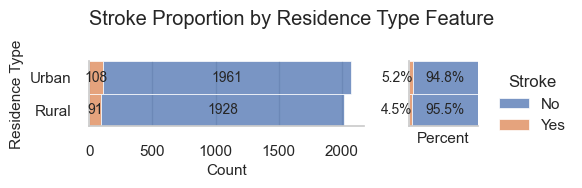

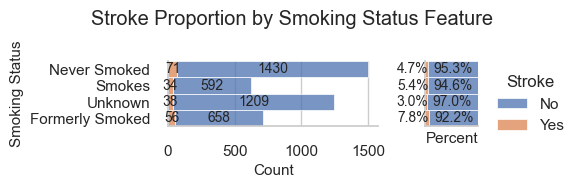

In [10]:
cat_features = data_eda.select_dtypes(include="object").columns.drop("Stroke")
for feature in cat_features:
    fig, _ = custom_plots.histplots_count_percent(
        df=data_eda,
        y=feature,
        hue="Stroke",
        hue_order=["No", "Yes"],
        title=f"Stroke Proportion by {feature} Feature",
    )
    fig.set_figheight(1.9)
    plt.show()

### 3.2. <a id='toc3_2_'></a>Variable Realtionships  [&#8593;](#toc0_)

The dataset contains variables of mixed types, so $Phi_{K}$ correlation coefficient is used in a correlation matrix. The coefficient is based on several refinements to Pearson’s hypothesis test of independence of two variables. It works consistently between categorical, ordinal and numerical variables, and captures non-linear dependency. The $Phi_{K}$ correlation coefficient reverts to the Pearson correlation coefficient in case of normal distributions.

Based on the correlation matrix for all ages, gender and residence type are not correlated with strokes events. BMI and work type also seems as almost not correlated. Smoking status, marital status, former hypertension or heart disease, as well as average glucose level all show very weak correlation with strokes events. Finally, only age shows low correlation with stroke events.

Age is highly correlated with marital status and work type because children, of course, have not been married before or worked. Also, age show moderate correlation with other features.

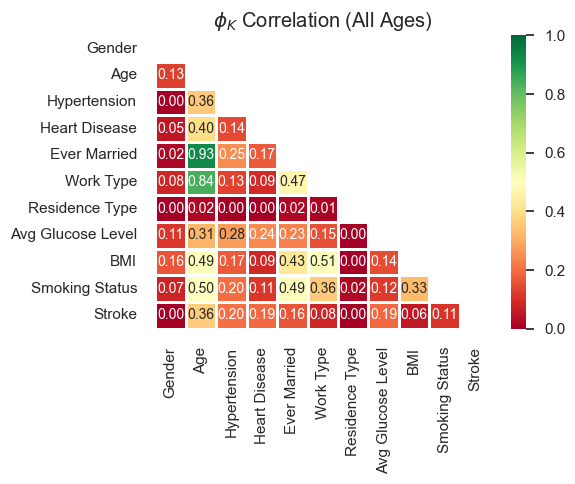

In [11]:
num_features = data_eda.select_dtypes(include="number")
phik_corr = data_eda.phik_matrix(interval_cols=num_features)
mask = np.triu(np.ones_like(phik_corr, dtype=bool))
plt.figure(figsize=(6, 5))
sns.heatmap(
    phik_corr,
    mask=mask,
    annot=True,
    cmap="RdYlGn",
    fmt=".2f",
    annot_kws={"size": 10},
    vmin=0,
    vmax=1,
    linewidths=1,
)
plt.title("$\phi_K$ Correlation (All Ages)")
plt.grid(False)
plt.show()

Age and BMI might have some concave relationship. Average glucose level tend to have higher variance at older age.

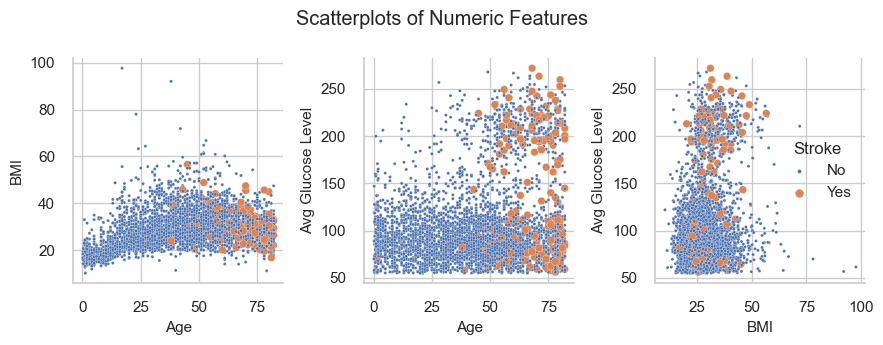

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3.5))
kw = {"hue": "Stroke", "size": "Stroke", "sizes": (30, 5)}
sns.scatterplot(data_eda, x="Age", y="BMI", ax=axs[0], **kw)
axs[0].legend("")
sns.scatterplot(data_eda, x="Age", y="Avg Glucose Level", ax=axs[1], **kw)
axs[1].legend("")
sns.scatterplot(data_eda, x="BMI", y="Avg Glucose Level", ax=axs[2], **kw)
fig.suptitle("Scatterplots of Numeric Features")
plt.show()

### 3.3. <a id='toc3_3_'></a>Possible Age Effect  [&#8593;](#toc0_)

The correlation matrix limited to patients older than 35 years old, exhibit smaller correlations across features. This shows that dataset has multicollinearity encoded in age. BMI exhibit no correlation with stroke events, but it might be useful if combined with other features.

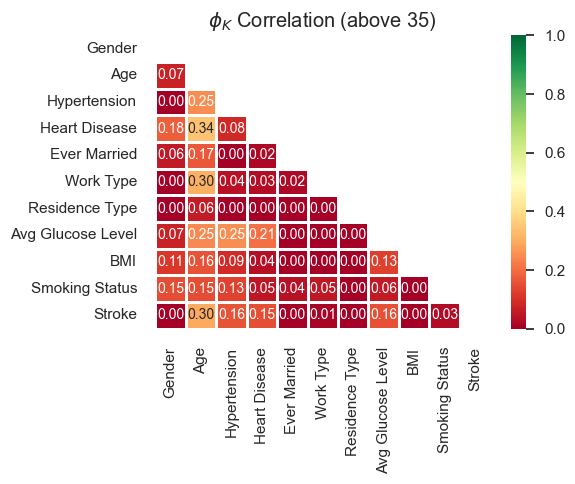

In [13]:
data_eda_above35 = data_eda[(data_eda["Age"] >= 35)].copy()
phik_corr = data_eda_above35.phik_matrix(interval_cols=num_features)
mask = np.triu(np.ones_like(phik_corr, dtype=bool))
plt.figure(figsize=(6, 5))
sns.heatmap(
    phik_corr,
    mask=mask,
    annot=True,
    cmap="RdYlGn",
    fmt=".2f",
    annot_kws={"size": 10},
    vmin=0,
    vmax=1,
    linewidths=1,
)
plt.title("$\phi_K$ Correlation (above 35)")
plt.grid(False)
plt.show()

Correlation between stroke events and marital status as well as work type dissapears as information about age is encoded in these features. Patients who formerly smoked tend to be older. By looking into distributions of age among smoking status, one might consider changing the category "Unknown" to "Never Smoked" for children under 10 years old.

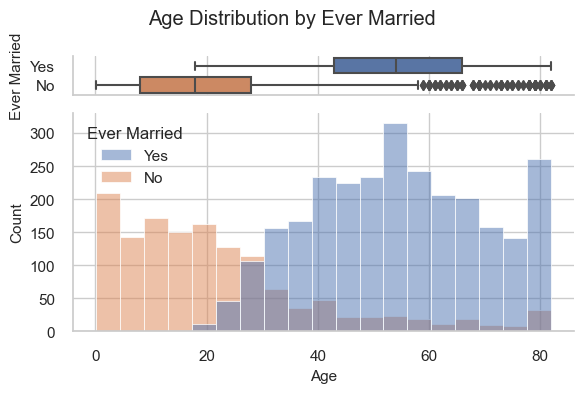

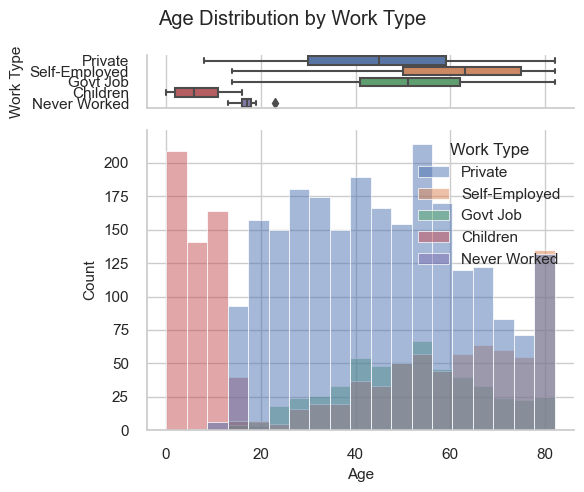

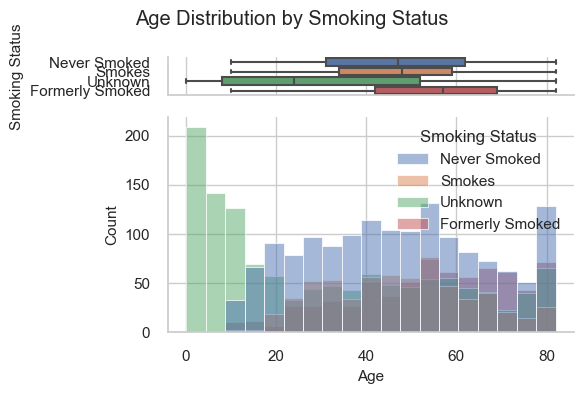

In [14]:
custom_plots.hist_box_plot(
    data_eda,
    x="Age",
    hue="Ever Married",
    title="Age Distribution by Ever Married",
)
fig = custom_plots.hist_box_plot(
    data_eda, x="Age", hue="Work Type", title="Age Distribution by Work Type"
)
fig.set_figheight(5)
custom_plots.hist_box_plot(
    data_eda,
    x="Age",
    hue="Smoking Status",
    title="Age Distribution by Smoking Status",
)
fig.set_figheight(5)
plt.show()

### 3.4. <a id='toc3_4_'></a>Summary on Exploratory Data Analysis  [&#8593;](#toc0_)

1. Age seems as the most important factor in stroke prediction. Though, increased average glucose level and presence of heart disease or hypertension also might be promising individual predictors.
2. Gender and residence type alone seem not to be related with stroke.
3. Though marital status and work type are correlated with stroke when investigating patients of all ages, these features seem to be highly correlated with age itself. Therefore, marital status and work type are removed from initial feature set for building the prediction model.
4. Stroke is very uncommon under the age of 40.

## 4. <a id='toc4_'></a>Statistical Inference    [&#8593;](#toc0_)

Cardiovascular diseases are well-known risk factors for stroke. However, it might be that they are not independent of age. Thus, the mean age of patients with and without stroke and other diseases are compared. The **null hypothesis** is raised that the means of age are equal for patients with and without stroke. The **alternative hypothesis** is that the means are not equal. **Population** here are patients with particular other diseases. **Parameter of interest** is difference in means. Since the distributions are not normal, a permutation test is performed at the significance level of $\alpha=0.05$.

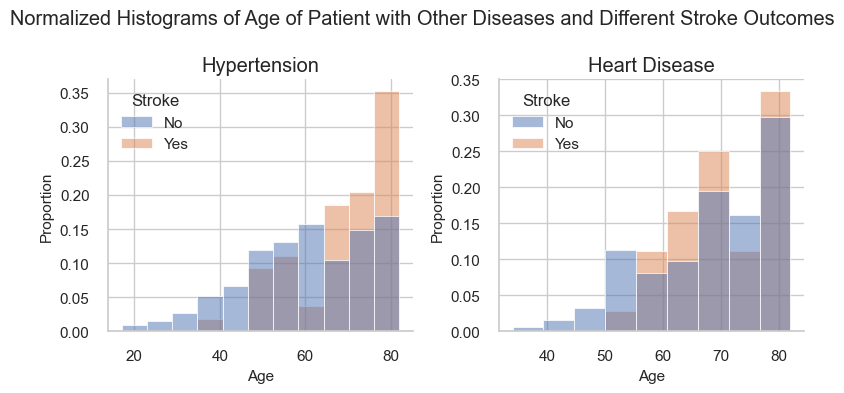

,Stroke Count,Non-Stroke Count,"Mean Age, Stroke","Mean Age, Non-Stroke",Mean Age Difference,Permutation p-value,Reject H0
Hypertension,54.0,343.0,69.37,60.81,8.56,0.000,Yes
Heart Disease,36.0,185.0,70.64,68.25,2.39,0.225,No


In [15]:
def statistic(x, y):
    return np.mean(x) - np.mean(y)


disease_cols = ["Hypertension", "Heart Disease"]
testing_num = pd.DataFrame(index=disease_cols)
alpha = 0.05
usevar = "unequal"
for feature in disease_cols:
    y0 = data_eda.loc[
        (data_eda[feature] == "Yes") & (data_eda["Stroke"] == "No"), "Age"
    ]
    y1 = data_eda.loc[
        (data_eda[feature] == "Yes") & (data_eda["Stroke"] == "Yes"), "Age"
    ]
    mean0 = round(np.mean(y0), 2)
    mean1 = round(np.mean(y1), 2)
    testing_num.loc[feature, "Stroke Count"] = len(y1)
    testing_num.loc[feature, "Non-Stroke Count"] = len(y0)
    testing_num.loc[feature, "Mean Age, Stroke"] = mean1
    testing_num.loc[feature, "Mean Age, Non-Stroke"] = mean0
    testing_num.loc[feature, "Mean Age Difference"] = mean1 - mean0
    res = stats.permutation_test((y0, y1), statistic)
    testing_num.loc[feature, "Permutation p-value"] = round(res.pvalue, 3)
testing_num["Reject H0"] = testing_num["Permutation p-value"].apply(
    lambda x: "Yes" if x < alpha else "No"
)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for idx, col in enumerate(disease_cols):
    ax = sns.histplot(
        data=data_eda[data_eda[col] == "Yes"],
        stat="proportion",
        common_norm=False,
        x="Age",
        hue="Stroke",
        hue_order=["No", "Yes"],
        ax=axes[idx],
        legend=True,
    )
    ax.set_title(col)
fig.suptitle(
    "Normalized Histograms of Age of Patient with Other Diseases and Different"
    " Stroke Outcomes"
)
plt.show()
testing_num

To investigate if numerical features are of importance when predicting if the patient will get stroke or not, means are compared. The **null hypothesis** is raised that the means of numerical features are equal for patients with and without stroke. The **alternative hypothesis** is that the means are not equal. **Population** here are patients. **Parameter of interest** is difference in numerical feature means. Since the distributions are not normal, a permutation test is performed at the significance level of $\alpha=0.05$.

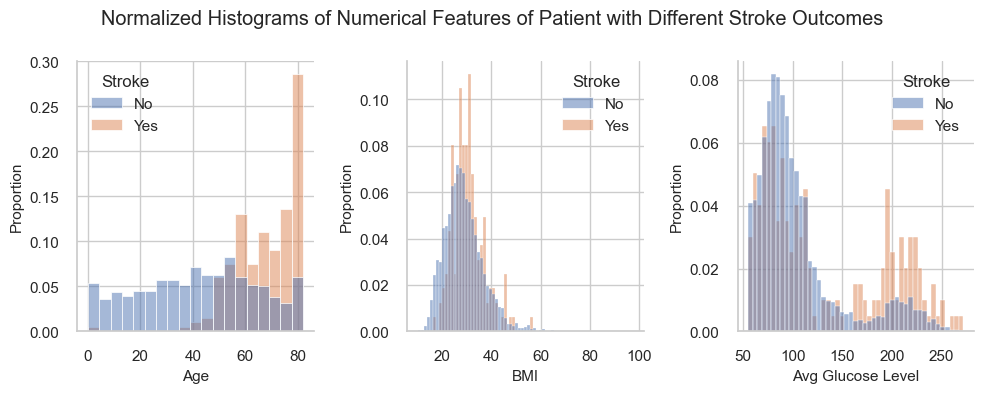

,Stroke Count,Non-Stroke Count,"Mean, Stroke","Mean, Non-Stroke",Mean Difference,Permutation p-value,Reject H0
Age,199.0,3889.0,67.66,42.11,25.55,0.0,Yes
BMI,199.0,3889.0,30.59,28.85,1.74,0.0,Yes
Avg Glucose Level,199.0,3889.0,131.39,105.03,26.36,0.0,Yes


In [16]:
testing_num = pd.DataFrame(index=num_cols)
alpha = 0.05
usevar = "unequal"
for feature in num_cols:
    y0 = data_eda.loc[(data_eda["Stroke"] == "No"), feature]
    y1 = data_eda.loc[(data_eda["Stroke"] == "Yes"), feature]
    mean0 = round(np.mean(y0), 2)
    mean1 = round(np.mean(y1), 2)
    testing_num.loc[feature, "Stroke Count"] = len(y1)
    testing_num.loc[feature, "Non-Stroke Count"] = len(y0)
    testing_num.loc[feature, "Mean, Stroke"] = mean1
    testing_num.loc[feature, "Mean, Non-Stroke"] = mean0
    testing_num.loc[feature, "Mean Difference"] = mean1 - mean0
    res = stats.permutation_test((y0, y1), statistic)
    testing_num.loc[feature, "Permutation p-value"] = round(res.pvalue, 3)
testing_num["Reject H0"] = testing_num["Permutation p-value"].apply(
    lambda x: "Yes" if x < alpha else "No"
)
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for idx, col in enumerate(num_cols):
    ax = sns.histplot(
        data=data_eda,
        stat="proportion",
        common_norm=False,
        x=col,
        hue="Stroke",
        hue_order=["No", "Yes"],
        ax=axes[idx],
        legend=True,
    )
fig.suptitle(
    "Normalized Histograms of Numerical Features of Patient with Different"
    " Stroke Outcomes"
)
plt.show()
testing_num

### 4.1. <a id='toc4_1_'></a>Summary on Statistical Inference  [&#8593;](#toc0_)

1. There is a significant difference in mean age of hypertensive patients who had and did not have stroke. This indicates that hypertension might be the factor showing the risk for the future at younger age.
2. There is no significant difference in mean age of heart disease patients who had and did not have stroke. Probably because this condition is more prevalent at older age, similarly to stroke.
3. Means of numerical features are significantly different in patients who had and did not have stroke. However, these differences are most apparent with age and average glucose level.

## 5. <a id='toc5_'></a>Model for Stroke Prediction    [&#8593;](#toc0_)

### 5.1. <a id='toc5_1_'></a>Model Selection  [&#8593;](#toc0_)

Initial preproccessing of data can be seen in `custom_pipes.py`. It contains removal of highly correlated features `ever_married` and `work_type`, as well as modification of `smoking_status` and its conversion to `ever_smoked`. 

At first, some untuned models are cross-validated. These include logistic regression (base model), random forest, XGBoost and LightGBM classifiers.

In [17]:
logreg = LogisticRegression(class_weight="balanced", random_state=0)
forest = RandomForestClassifier(
    class_weight="balanced", random_state=0, max_depth=5, max_leaf_nodes=10
)
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]
xgb = XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    random_state=0,
    max_depth=5,
    max_leaves=10,
)
lgbm = LGBMClassifier(
    class_weight="balanced",
    random_state=0,
    max_depth=5,
    num_leaves=10,
    verbose=-1,
)
pipe_logreg = custom_pipes.build_full_pipe(logreg)
pipe_logreg.set_params(
    preprocessor__num__impute=SimpleImputer(strategy="mean"),
    preprocessor__num__scale=StandardScaler(),
)
pipe_forest = custom_pipes.build_full_pipe(forest)
pipe_forest.set_params(
    preprocessor__num__impute=SimpleImputer(strategy="mean")
)
pipe_xgb = custom_pipes.build_full_pipe(xgb)
pipe_lgbm = custom_pipes.build_full_pipe(lgbm)
pipe_logreg.fit(X_train, y_train)
pipe_forest.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)
pipe_lgbm.fit(X_train, y_train)

fig = custom_model.cv_score_binary_classifiers(
    ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM"],
    [pipe_logreg, pipe_forest, pipe_xgb, pipe_lgbm],
    fold=5,
    X=X_train,
    y=y_train,
)

,AUC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC
Logistic Regression,0.843,0.189,0.799,0.133,0.736,0.766,0.229,0.400,0.252
Random Forest,0.834,0.180,0.845,0.126,0.705,0.771,0.219,0.394,0.249
XGBoost,0.815,0.196,0.398,0.171,0.878,0.650,0.239,0.314,0.203
LightGBM,0.830,0.216,0.628,0.156,0.816,0.727,0.250,0.391,0.246


Model hyperparameters are tuned in a separate notebook `appendix_hyperparameter_tuning.ipynb`. Models are optimized for average precision. The cross-validated performance of tuned models is as follows. XGBoost classifier provides the highest average precision.

In [18]:
best_logreg = joblib.load("./tuned_models/best_logreg.sav")
best_forest = joblib.load("./tuned_models/best_forest.sav")
best_xgb = joblib.load("./tuned_models/best_xgb.sav")
best_lgbm = joblib.load("./tuned_models/best_lgbm.sav")
fig = custom_model.cv_score_binary_classifiers(
    ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM"],
    [best_logreg, best_forest, best_xgb, best_lgbm],
    fold=5,
    X=X_train,
    y=y_train,
)

,AUC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC
Logistic Regression,0.842,0.191,0.824,0.135,0.733,0.776,0.232,0.408,0.260
Random Forest,0.835,0.192,0.835,0.123,0.701,0.764,0.214,0.386,0.242
XGBoost,0.854,0.248,0.885,0.121,0.682,0.778,0.213,0.392,0.250
LightGBM,0.842,0.245,0.970,0.089,0.512,0.729,0.163,0.324,0.198


### 5.2. <a id='toc5_2_'></a>Important Features and Threshold Tuning  [&#8593;](#toc0_)

Using *Boruta* algorithm, only the important features are kept for XGBoost classifier.

In [19]:
preprocessor_pipe = Pipeline(best_xgb.steps[:-1])
clf = clone(best_xgb.named_steps["model"])
X_train_transformed = preprocessor_pipe.fit_transform(X_train)
feat_selector = BorutaPy(clf, n_estimators="auto", verbose=0, random_state=0)
feat_selector.fit(X_train_transformed.values, y_train.values)
feature_ranks = list(
    zip(
        X_train_transformed.columns,
        feat_selector.ranking_,
        feat_selector.support_,
    )
)
for feat in feature_ranks:
    print(f"Feature: {feat[0]:<25} Keep: {feat[2]}, Rank: {feat[1]}")

Feature: age                       Keep: True, Rank: 1
Feature: avg_glucose_level         Keep: True, Rank: 1
Feature: bmi                       Keep: True, Rank: 1
Feature: hypertension              Keep: True, Rank: 1
Feature: heart_disease             Keep: True, Rank: 1
Feature: gender_female             Keep: False, Rank: 2
Feature: gender_male               Keep: False, Rank: 3
Feature: residence_type_Urban      Keep: False, Rank: 6
Feature: residence_type_Rural      Keep: False, Rank: 7
Feature: ever_smoked_No            Keep: False, Rank: 4
Feature: ever_smoked_Yes           Keep: False, Rank: 4


Since none of the selected features needs the preprocessing of the `CleaningTransformer`, this transformer ir removed from the pipeline and replaced with the selector for the important features.

In [20]:
keep_cols = X_train_transformed.columns[feat_selector.support_].to_list()
best_xgb.steps.pop(0)
best_xgb.steps.insert(
    0,
    (
        "selector",
        ColumnTransformer(
            [("selector", "passthrough", keep_cols)],
            verbose_feature_names_out=False,
        ).set_output(transform="pandas"),
    ),
)

Since the classifier was tuned for average precision, its decision threshold is tuned so that the 10th percentile of recall is at least 0.8.

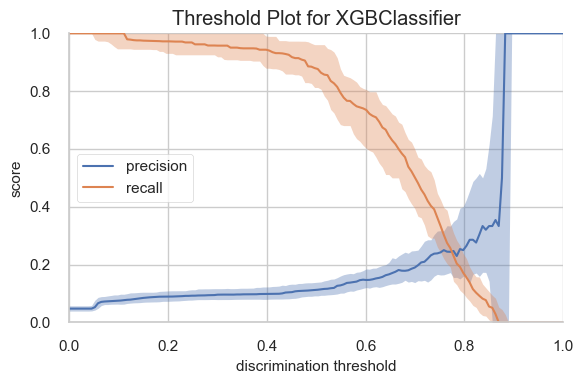

,precision,precision_lower,precision_upper,recall,recall_lower,recall_upper
0.51,0.114,0.094,0.14,0.864,0.806,0.961


In [21]:
visualizer = DiscriminationThreshold(
    best_xgb, exclude=["queue_rate", "fscore"], random_state=0, cv=0.2
)
visualizer.fit(X_train, y_train)
visualizer.show()
tun_th = pd.DataFrame(visualizer.cv_scores_, index=visualizer.thresholds_)
tun_th.index.name = "threshold"
threshold = tun_th.loc[(tun_th["recall_lower"] >= 0.8), "precision"].idxmax()
pd.DataFrame(tun_th.loc[threshold]).T

The threshold is integrated in the final pipeline.

In [22]:
best_xgb_tuned = Thresholder(best_xgb, threshold=threshold, refit=False)
best_xgb_tuned.fit(X_train, y_train)

Thresholder(model=Pipeline(steps=[('selector',
                                   ColumnTransformer(transformers=[('selector',
                                                                    'passthrough',
                                                                    ['age',
                                                                     'avg_glucose_level',
                                                                     'bmi',
                                                                     'hypertension',
                                                                     'heart_disease'])],
                                                     verbose_feature_names_out=False)),
                                  ('preprocessor',
                                   ColumnTransformer(transformers=[('num',
                                                                    Pipeline(steps=[('impute',
                                                                                     SimpleImputer(fill_value=0,
                                                                                                   strategy='constant')),
                                                                                    ('scale',
                                                                                     None)]...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=2, max_leaves=None,
                                                 min_child_weight=3,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=31, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=0, ...))]),
            threshold=0.5098039215686274)

### 5.3. <a id='toc5_3_'></a>Model Evaluation  [&#8593;](#toc0_)

#### 5.3.1. <a id='toc5_3_1_'></a>Training Set  [&#8593;](#toc0_)

The final threshold-tuned classifier obtains recall and precision of 89.9% and 12.1%, respectively, on the training set.

,AUC-ROC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC
XGBoost,0.873,0.255,0.899,0.121,0.677,0.783,0.213,0.394,0.253


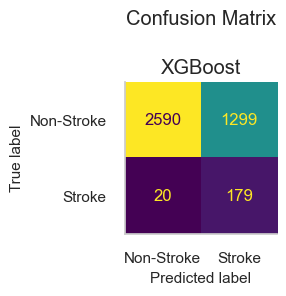

In [23]:
fig = custom_model.score_binary_fitted_classifiers(
    ["XGBoost"],
    [best_xgb_tuned],
    X=X_train,
    y=y_train,
    labels=["Non-Stroke", "Stroke"],
)
fig.set_figheight(3)

By inspecting the false negatives, we can see that these are relatively young patients without other diseases and normal glucose level in most cases. Such errors might be expected.

In [24]:
df = X_train.copy()
df["true"] = y_train
df["predicted"] = best_xgb_tuned.predict(X_train)
print("FALSE NEGATIVES ON THE TRAINING SET:")
df[(df["true"] == 1) & (df["predicted"] == 0)]

FALSE NEGATIVES ON THE TRAINING SET:


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,true,predicted
id,,,,,,,,,,,,
19773,Female,52.00,0,0,Yes,Private,Rural,96.59,26.4,never smoked,1,0
41069,Female,45.00,0,0,Yes,Private,Rural,224.10,56.6,never smoked,1,0
54567,Female,46.00,0,0,Yes,Private,Urban,78.18,30.8,never smoked,1,0
14248,Male,48.00,0,0,No,Govt_job,Urban,84.20,29.7,never smoked,1,0
59125,Female,53.00,0,0,Yes,Govt_job,Urban,64.17,41.5,never smoked,1,0
62439,Female,51.00,0,0,Yes,Govt_job,Rural,103.43,27.3,formerly smoked,1,0
12175,Female,54.00,0,0,Yes,Private,Urban,104.51,27.3,smokes,1,0
62019,Male,54.00,0,0,Yes,Govt_job,Rural,87.85,31.1,smokes,1,0
32399,Male,54.00,0,0,Yes,Private,Rural,96.97,29.1,smokes,1,0


False positives under the age of 50 are all for patients older than 48 years, with hypertension or high glucose level and BMI. Such errors might be expected and would be even more common in older patients.

In [25]:
print("FALSE POSITIVES ON THE TRAINING SET (UNDER THE AGE OF 50):")
df[(df["true"] == 0) & (df["predicted"] == 1) & (df["age"] < 50)]

FALSE POSITIVES ON THE TRAINING SET (UNDER THE AGE OF 50):


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,true,predicted
id,,,,,,,,,,,,
60675,Female,48.0,1,0,Yes,Govt_job,Rural,221.08,57.2,never smoked,0,1
22440,Female,49.0,0,0,Yes,Private,Urban,267.76,29.3,formerly smoked,0,1
5714,Female,49.0,1,0,Yes,Govt_job,Rural,98.90,35.5,never smoked,0,1
15515,Female,48.0,0,0,Yes,Self-employed,Rural,209.90,NaN,smokes,0,1
60088,Male,49.0,1,0,Yes,Self-employed,Rural,92.26,33.1,formerly smoked,0,1
66893,Male,49.0,1,0,Yes,Govt_job,Urban,139.43,40.2,formerly smoked,0,1
54177,Female,49.0,1,0,Yes,Govt_job,Rural,63.16,23.3,formerly smoked,0,1
65907,Female,49.0,0,0,Yes,Private,Urban,206.53,44.5,smokes,0,1
66431,Male,49.0,0,0,Yes,Private,Urban,209.06,43.8,Unknown,0,1


#### 5.3.2. <a id='toc5_3_2_'></a>Test Set  [&#8593;](#toc0_)

The final threshold-tuned classifier obtains recall and precision of 84% and 11.8%, respectively, on the test set.

,AUC-ROC,Average Precision,Recall,Precision,Accuracy,Balanced Accuracy,F1,F-beta,MCC
XGBoost,0.844,0.252,0.840,0.118,0.686,0.759,0.207,0.378,0.235


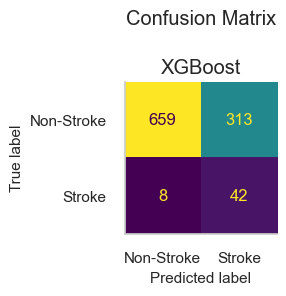

In [26]:
fig = custom_model.score_binary_fitted_classifiers(
    ["XGBoost"],
    [best_xgb_tuned],
    X=X_test,
    y=y_test,
    labels=["Non-Stroke", "Stroke"],
)
fig.set_figheight(3)

False negatives, again, are encountered with relatively young patients without other diseases and normal glucose level. Such errors might be expected.

In [27]:
df = X_test.copy()
df["true"] = y_test
df["predicted"] = best_xgb_tuned.predict(X_test)
print("FALSE NEGATIVES ON THE TEST SET:")
df[(df["true"] == 1) & (df["predicted"] == 0)]

FALSE NEGATIVES ON THE TEST SET:


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,true,predicted
id,,,,,,,,,,,,
31563,Female,38.0,0,0,Yes,Private,Rural,101.45,NaN,formerly smoked,1,0
54385,Male,45.0,0,0,Yes,Private,Rural,64.14,29.4,never smoked,1,0
39912,Female,32.0,0,0,Yes,Private,Rural,76.13,29.9,smokes,1,0
14499,Male,47.0,0,0,Yes,Private,Urban,86.94,41.1,formerly smoked,1,0
33943,Female,39.0,0,0,Yes,Private,Urban,83.24,26.3,never smoked,1,0
49669,Female,14.0,0,0,No,children,Rural,57.93,30.9,Unknown,1,0
33879,Male,42.0,0,0,Yes,Private,Rural,83.41,25.4,Unknown,1,0
31154,Female,39.0,0,0,Yes,Self-employed,Urban,97.76,29.6,smokes,1,0


False positives under the age of 50 are encountered in patients older than 48, with other diseases, abnormal glucose level or BMI. Such errors might be expected.

In [28]:
print("FALSE POSITIVES ON THE TEST SET (UNDER THE AGE OF 50):")
df[(df["true"] == 0) & (df["predicted"] == 1) & (df["age"] < 50)]

FALSE POSITIVES ON THE TEST SET (UNDER THE AGE OF 50):


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,true,predicted
id,,,,,,,,,,,,
29878,Male,49.0,0,0,Yes,Private,Urban,175.74,45.4,Unknown,0,1
68995,Female,48.0,1,0,No,Private,Rural,118.14,NaN,formerly smoked,0,1
32604,Male,49.0,0,0,Yes,Self-employed,Rural,215.81,58.1,never smoked,0,1
66680,Female,49.0,1,0,Yes,Private,Rural,65.34,39.4,never smoked,0,1


### 5.4. <a id='toc5_4_'></a>Model Interpretation  [&#8593;](#toc0_)

SHAP values of the features on the test set show that age is, indeed, the most important predictor. It also seems that high glucose level and very high or very low BMI influence stroke prediction. The presence of hypertension and heart disease also increase the risk of stroke.

[21:07:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


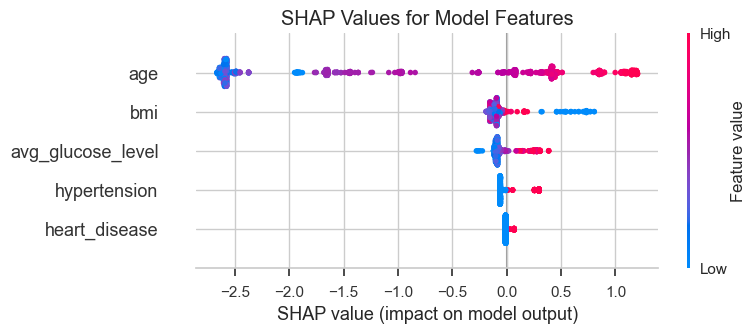

In [29]:
preprocessor_pipe = Pipeline(best_xgb.steps[:-1])
clf = clone(best_xgb.named_steps["model"])
X_train_transformed = preprocessor_pipe.fit_transform(X_train)
clf.fit(X_train_transformed, y_train)
X_test_transformed = preprocessor_pipe.transform(X_test)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed, show=False)
plt.title("SHAP Values for Model Features")
plt.show()

As could be expected, SHAP values for ages below 40 are low. Only high BMI increases those a bit. On the contrary, with higher age, very low BMI tend to yield slightly higher SHAP values.

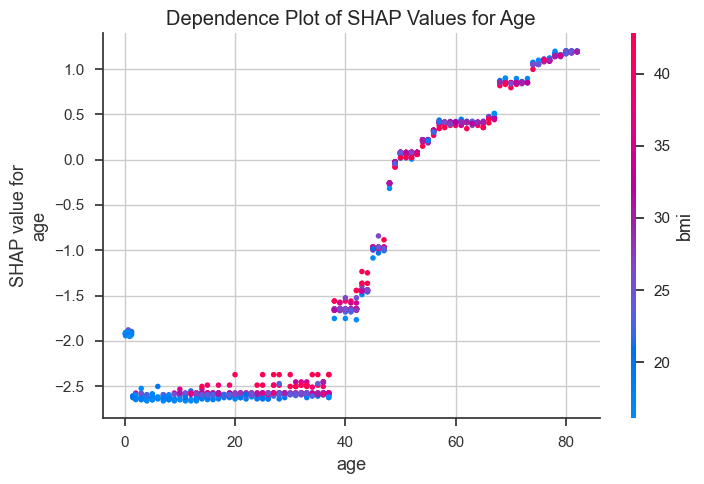

In [30]:
shap.dependence_plot(
    "age", shap_values, X_test_transformed, interaction_index="bmi", show=False
)
plt.title("Dependence Plot of SHAP Values for Age")
plt.show()

Below is one of the examples of a patient from the test set. The risk for stroke is highly driven by the old age, presence of hypertension and high average glucose level. Quite surprisingly, very high BMI tends to decrease the predicted risk a bit.

,age,avg_glucose_level,bmi,hypertension,heart_disease
28674,74.0,205.84,54.6,1.0,0.0


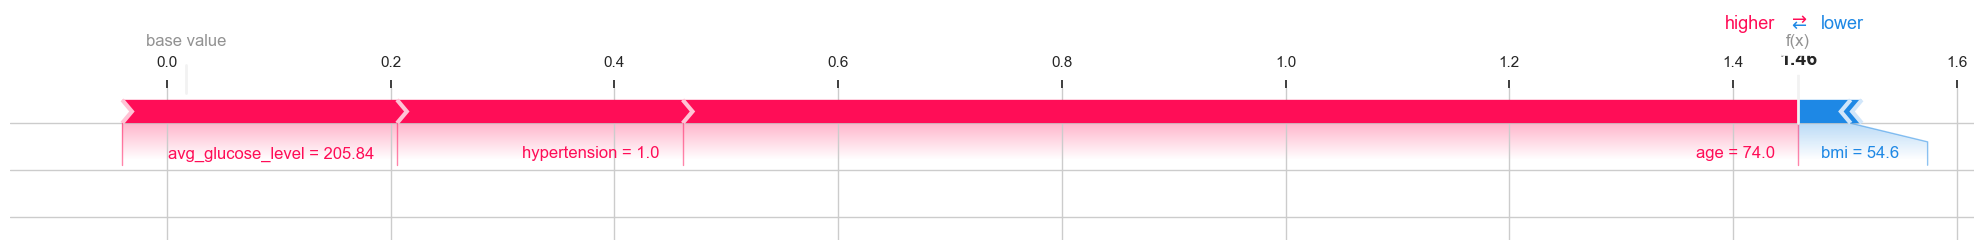

In [31]:
display(pd.DataFrame(X_test_transformed.iloc[10, :]).T)
shap.force_plot(
    explainer.expected_value,
    shap_values[10, :],
    X_test_transformed.iloc[10, :],
    matplotlib=True,
)

### 5.5. <a id='toc5_5_'></a>Model Deployment [&#8593;](#toc0_)

Tuned XGBoost classifier is deployed locally in a container using `FastAPI` and `Docker`. Necessary files can be found in `deployment` folder.

In [32]:
joblib.dump(best_xgb_tuned, "./deployment/model.joblib")

['./deployment/model.joblib']

### 5.6. <a id='toc5_6_'></a>Summary on Model for Stroke Prediction [&#8593;](#toc0_)

1. Out of logistic regression, random forest, XGBoost and LightGBM classifiers, XGBoost showed highest average precision on the training set.
2. Gender, smoking, and residence type were yielded as unimportant features for stroke risk prediction.
3. The final threshold-tuned XGBoost classifier obtained 89.9% and 12.1% recall and precision on the training set, and 84% and 11.8% recall and precision on the test set.
4. Errors made by the classifier were expectable and understandable from the domain knowledge perspective.
5. Age remained the most important feature in predicting stroke risk.

## 6. <a id='toc6_'></a>Recommendations    [&#8593;](#toc0_)

Based on the analysis of the provided Stroke Prediction Dataset, the following recommendations could be useful:
1. Older age is the most relevant predictor for stroke risk. To identify risk of stroke in patients younger than 40, more data and more sophisticated features might be needed.
2. Presence of hypertension and higher average glucose level (diabetes) also indicate the increased risk of stroke. On the other hand, body mass index seems to yield contradictory results with stroke risk increasing at high and very low values.
3. Patients with hypertension may get stroke at older age. Thus, hypertension at younger age may show the risk of stroke for the future.
4. Gender, residence type, marital status, work type, ever smoking ended up to be non-important factors for stroke prediction.
5. The final classifier is able to predict stroke with 84% recall, but only 12% precision asking for additional human input in assessing the true risk of stroke. 
6. High number of false positives may indicate patients, who did not suffer from stroke, but might be at a high risk in the near future. 

## 7. <a id='toc7_'></a>Suggestions for Improvement    [&#8593;](#toc0_)

The analysis of the Stroke Prediction Dataset can be improved:
* Building of the prediction model could be limited to patients older than 40 years.
* The full potential of body mass index feature could be revealed by more sophisticated imputation of missing values and its conversion into categorical feature of Underweight/Normal/Overweight/Obese by comparing values to specific tables.
* Based on medical literature, gender might have a slight effect on stroke risk. More data might be needed to reveal this effect.
* The feature of patient ever smoking was not informative enough to be included in the final model. However, medical literature indicates that smoking increases the risk of stroke. Thus, the feature might need re-engineering to better represent the current smoking status.